scRNA-seqデータのPythonによる解析を通して、scRNA-seq解析プラットフォームの中で起きている計算への理解を深める。  
また、以下で紹介する手法は、シングルセルに限らず様々な生物学実験で生成される「テーブル形式」のデータに適用できる。  
自分のフィールドで扱うテーブルに適用した場合にどんな結果や解釈が得られるか、想像しながら実行することを勧める。

In [ ]:
!pip install scanpy umap-learn anndata numpy scipy sklearn pandas matplotlib scrublet seaborn python-igraph leidenalg

必要なライブラリのインポート、および、ちょっとした設定。

In [ ]:
import os
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import scrublet as scr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns

plt.rcParams['figure.figsize']=(8,8)
sc.settings.verbosity = 3
sc.logging.print_versions()

# データの読み込みと前処理

## データの読み込み

Cell Ranger 3.1.0解析済みのデータは10x Genomicsの [ここのデータ](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.1.0/5k_pbmc_protein_v3) からダウンロード。

5k Peripheral blood mononuclear cells (PBMCs) from a healthy donor with cell surface proteins (v3 chemistry) 

5,247 cells detected

以下のURLからダウンロードし、解凍する。

In [ ]:
%%bash
wget http://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.tar.gz -O 5k_pbmc_protein_v3_filtered_feature_bc_matrix.tar.gz
tar -xzvf 5k_pbmc_protein_v3_filtered_feature_bc_matrix.tar.gz

Scanpyの特徴は、データフレームを拡張した ***anndata*** と呼ばれる オブジェクトを使う点にある。anndataを使うと、ひとつのオブジェクト に遺伝子発現量のデータ、サンプルや細胞のアノテーション、遺伝子の 情報などをまとめて格納できる。
anndataを使うことで、実験の情報が詰まったひとつのオブジェクトに対して処理を次々に実行し、 さらに処理結果をそこに蓄積していくことができる。

* anndataの構造。詳細は https://anndata.readthedocs.io/en/latest/
<img src="https://anndata.readthedocs.io/en/latest/_images/anndata_schema.svg" alt="anndata_object" width="600"/>

Scanpyでは、10x Genomicsのデータは、結果のディレクトリを指定することでそのままロードが可能な関数が用意されている。

ディレクトリには、3つのファイルが書き出されている。

ひとつは、個別の細胞を識別するバーコードが記述された```barcodes.tsv```という名前のテキストファイルである。
各行ごとにひとつのバーコードが記述されている。

ふたつめは、計測された遺伝子が記述された```genes.tsv```という名前のタブ区切りテキストファイルである。
このファイルは左側の列に遺伝子のENSEMBL Gene ID、右側の列の遺伝子のシンボルが記述されている。

最後に```matrix.mtx```というテキストファイルが、各細胞（バーコード）について各遺伝子の発現がいくつ観測されたのかカウント情報をまとめたファイルである。
このファイルはMatrix Market Exchange Formatsという形式で記述されており、疎行列（含まれる値の多くがゼロであるような行列）を比較的コンパクトに記述するための形式となっている。

Scanpyの10xデータ用読み込み関数を使うと、これらを同時に読み込んで、適切に構造化されたオブジェクトができあがる。

In [4]:
adata = sc.read_10x_mtx(path="./filtered_feature_bc_matrix/")

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


データの構造を見てみる。

以下のように、5,247細胞、33,538遺伝子の情報を記録したテーブルとなっている。

In [5]:
adata.shape

(5247, 33538)

カウントテーブルには、以下のように ***X*** でアクセスできる。疎行列として格納されている。

In [6]:
adata.X

<5247x33538 sparse matrix of type '<class 'numpy.float32'>'
	with 9250566 stored elements in Compressed Sparse Row format>

観測値（細胞）に関するデータは、 ***obs*** でアクセスする。 observation の略。現在は細胞ひとつひとつのバーコード配列のデータだけが紐づいているが、ここに細胞に関するデータは追加していくことができる。

In [7]:
adata.obs

""
AAACCCAAGAGACAAG-1
AAACCCAAGGCCTAGA-1
AAACCCAGTCGTGCCA-1
AAACCCATCGTGCATA-1
AAACGAAAGACAAGCC-1
...
TTTGTTGCAGCACAAG-1
TTTGTTGCAGTCTTCC-1
TTTGTTGCATGGCCCA-1
TTTGTTGCATTGCCGG-1


変数（遺伝子）に関するデータは、 ***var*** でアクセスする。 variable の略。現在は、遺伝子のシンボル（名前）と、Ensembl Gene IDなどが登録されている。

In [8]:
adata.var

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC233755.2,ENSG00000277856,Gene Expression
AC233755.1,ENSG00000275063,Gene Expression
AC240274.1,ENSG00000271254,Gene Expression
AC213203.1,ENSG00000277475,Gene Expression


## データのクオリティコントロール（フィルタリング）

参考：[Seuratのチュートリアル](https://satijalab.org/seurat/v3.1/pbmc3k_tutorial.html)    

クオリティコントロールは基本的に、以下の二段階で行う。
1. 細胞のフィルタリング（クオリティがダメな細胞を除去）
2. 遺伝子のフィルタリング（あまり価値のある情報を持たない遺伝子などを除去）


まずは細胞のフィルタリングから。

単純な方針として、あまりリードがアサインされなかったスカスカな細胞や、ミトコンドリア遺伝子の発現割合が高すぎて状態が怪しい細胞を捨てる。

細胞ごとのトータルのカウント、検出遺伝子数、ミトコンドリア遺伝子の発現量割合などは、通常のNumpyの場合と同様に計算できる。基本的に```numpy.ndarray```ではなく```numpy.matrix```クラスで情報が格納されているので、```numpy.matrix.A1```関数を使ってデータを変換する必要がある点が若干異なる。

※ヒトの場合、ミトコンドリアにコードされている遺伝子は名前が "MT-" からはじまるので、抽出も簡単。

In [9]:
import numpy as np
# numpy.matrix.A1関数で疎行列の足し算結果をnumpy.ndarrayオブジェクトに変換する

# 細胞ごとのカウント。発現量テーブル（X）の横方向の和
adata.obs['counts'] = adata.X.sum(axis=1).A1

# 検出遺伝子数
adata.obs['n_genes'] = (adata.X > 0.0).astype(int).sum(axis=1).A1

# ミトコンドリア遺伝子発現量割合
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = 100.0 * np.sum(adata[:, mito_genes].X, axis=1).A1\
                            / np.sum(adata.X, axis=1).A1

adata.obs

,counts,n_genes,percent_mito
AAACCCAAGAGACAAG-1,7359.0,2359,6.332382
AAACCCAAGGCCTAGA-1,3764.0,1255,9.112646
AAACCCAGTCGTGCCA-1,4894.0,1575,13.179403
AAACCCATCGTGCATA-1,6700.0,1905,6.358209
AAACGAAAGACAAGCC-1,3894.0,1587,9.322034
...,...,...,...
TTTGTTGCAGCACAAG-1,4740.0,1641,9.852321
TTTGTTGCAGTCTTCC-1,6367.0,1900,8.685410
TTTGTTGCATGGCCCA-1,1110.0,496,34.504505
TTTGTTGCATTGCCGG-1,12207.0,3442,10.534939


これらの関係を可視化してみる。

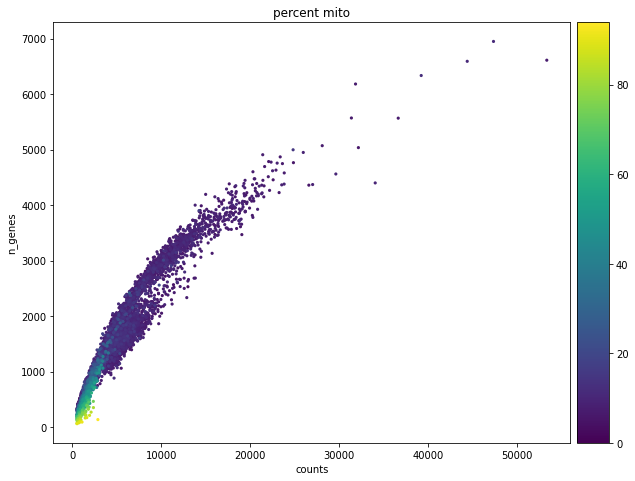

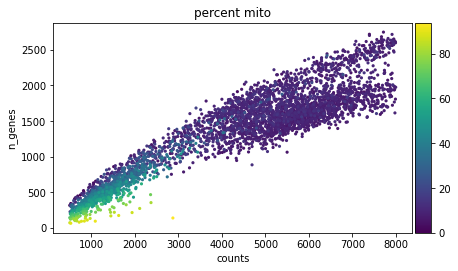

In [10]:
p1 = sc.pl.scatter(adata, 'counts', 'n_genes', color='percent_mito', size=40)
p2 = sc.pl.scatter(adata[adata.obs['counts']<8000], 'counts', 'n_genes', 
                   color='percent_mito', size=40)

アサインされたリードが少ない細胞（スカスカな細胞）は、全体に占めるミトコンドリア遺伝子の発現量がきわめて高い傾向があることがわかる。このへんは捨てる対象の候補。

リードカウントの分布をもう少し詳しく見てみる。

<Figure size 432x288 with 0 Axes>

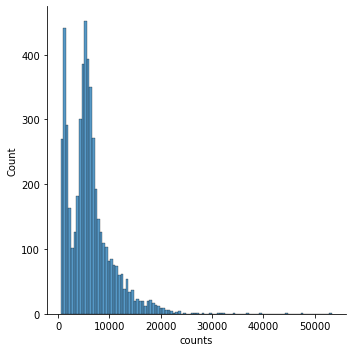

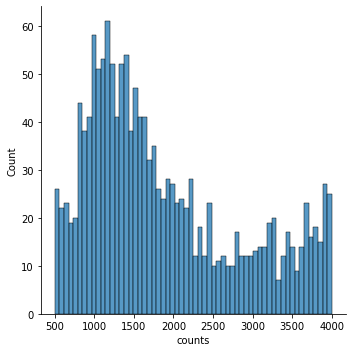

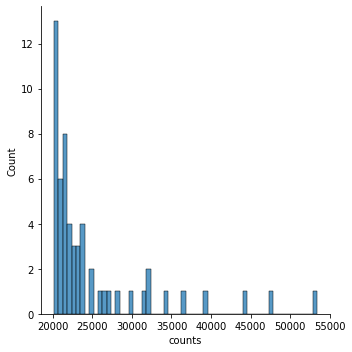

In [11]:
fig = plt.figure()
p3 = sns.displot(adata.obs['counts'], kde=False)
p4 = sns.displot(adata.obs['counts'][adata.obs['counts']<4000], kde=False, bins=60)
p5 = sns.displot(adata.obs['counts'][adata.obs['counts']>20000], kde=False, bins=60)
plt.show()

遺伝子検出数、ミトコンドリア遺伝子発現割合についても同様にヒストグラムがかける。これらのデータから、フィルタリングの範囲を決める。

<Figure size 432x288 with 0 Axes>

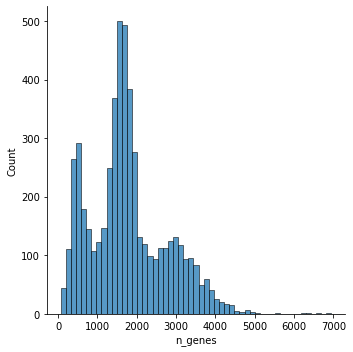

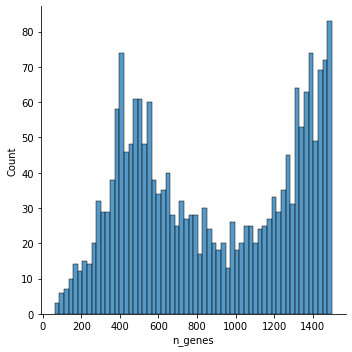

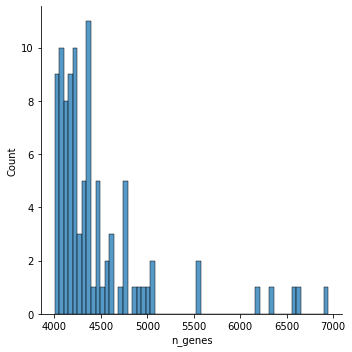

In [12]:
fig = plt.figure()
p6 = sns.displot(adata.obs['n_genes'], kde=False)
p7 = sns.displot(adata.obs['n_genes'][adata.obs['n_genes']<1500], kde=False, bins=60)
p8 = sns.displot(adata.obs['n_genes'][adata.obs['n_genes']>4000], kde=False, bins=60)
plt.show()

<Figure size 432x288 with 0 Axes>

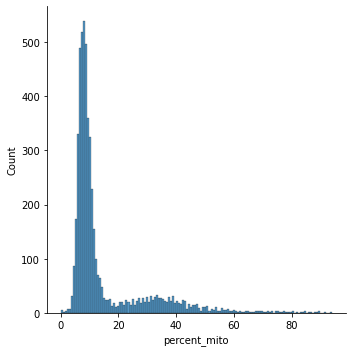

In [13]:
fig = plt.figure()
p9 = sns.displot(adata.obs['percent_mito'], kde=False)
plt.show()

方針を決めたら実際にフィルタリングを実行する。

In [14]:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 2500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 25000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['percent_mito'] < 20]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 5247
filtered out 1159 cells that have less than 2500 counts
Number of cells after min count filter: 4088
filtered out 14 cells that have more than 25000 counts
Number of cells after max count filter: 4074
Number of cells after MT filter: 3987
filtered out 34 cells that have less than 1000 genes expressed
Number of cells after gene filter: 3953


/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


次に、遺伝子のフィルタリング。

あまりに少ない細胞でしか発現していない遺伝子は有用な情報を持たないため捨てる。ここでは20細胞を閾値とする。

In [15]:
print('Total number of genes: {:d}'.format(adata.n_vars))

sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33538
filtered out 20234 genes that are detected in less than 20 cells
Number of genes after cell filter: 13304


scRNA-seqにおける重要なアーティファクト、「ダブレット」

Scrubletツールを使ってそれぞれの細胞に「ダブレットスコア」（ダブレットの疑わしさの指標）を計算する。

In [16]:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.02 
sim_doublet_ratio = 3
n_neighbors = 15

scrub = scr.Scrublet(counts_matrix = adata.X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)

doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)

adata.obs['doublet_score'] = doublet_scores
adata.obs['doublet'] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.13
Detected doublet rate = 1.4%
Estimated detectable doublet fraction = 47.0%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.0%
Elapsed time: 4.4 seconds


ダブレットスコアの分布を見てみる。

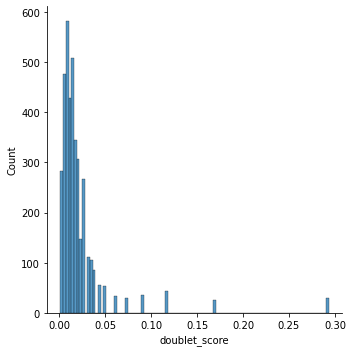

In [17]:
sns.displot(adata.obs['doublet_score'], bins=100, kde=False)
plt.show()

Scrubletが提案する閾値0.13はちょっとゆるい気がするので、ここでは0.05に設定してフィルタリングする。

In [18]:
thr = 0.05
ix_filt = adata.obs['doublet_score']<=thr

adata = adata[ix_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells after doublet filter: 3702


以上で細胞、遺伝子のフィルタリングが終わった。

最終的なテーブルは以下のサイズとなった。

In [19]:
print(adata.shape)

(3702, 13304)


## 正規化（Normalization）

ライブラリサイズによる正規化、対数変換などの前処理は、```scanpy.pp```以下にいくつか便利な関数がある。

まず、生のカウントデータは上書きしないように別の場所に退避させておく。

In [20]:
adata.layers['counts'] = adata.X.copy()

細胞ごとのカウントで、和が10,000になるように正規化して、対数変換。

In [21]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## 特徴量選択（発現量の変動が大きい遺伝子）

発現量変動の大きい遺伝子のみを抽出して、データのサイズを小さくする。内部の計算では、平均発現量の値の大きさでいくつか区分けして、それぞれでDispersionを計算しているため、単純に平均と分散で決めるよりも複雑なことをしている。とはいえ、それもひとつの関数で簡単に実行できる。

In [22]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


抽出された遺伝子を可視化してみる。

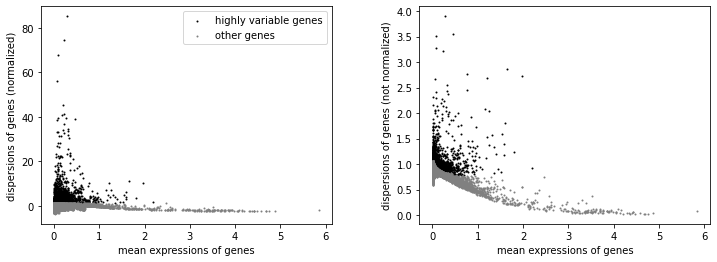

In [23]:
sc.pl.highly_variable_genes(adata)

計算結果は自動的に ***adata.var*** 、つまり、遺伝子に関するメタデータを格納したオブジェクトに追加される。 ***highly_variable*** の項目が True の遺伝子が高発現変動遺伝子。

In [24]:
adata.var

,gene_ids,feature_types,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,26,False,0.005845,0.917747,-0.046824
AL669831.5,ENSG00000237491,Gene Expression,247,False,0.051417,0.874620,-0.513738
LINC00115,ENSG00000225880,Gene Expression,204,False,0.042082,0.871599,-0.574784
FAM41C,ENSG00000230368,Gene Expression,76,False,0.015055,0.852832,-1.170461
NOC2L,ENSG00000188976,Gene Expression,894,False,0.208106,0.811315,0.104966
...,...,...,...,...,...,...,...
MAFIP,ENSG00000274847,Gene Expression,38,False,0.008032,0.920359,-0.021623
AL592183.1,ENSG00000273748,Gene Expression,328,False,0.072533,0.892196,0.300431
AC007325.4,ENSG00000278817,Gene Expression,37,False,0.007201,0.870911,-0.498716
AL354822.1,ENSG00000278384,Gene Expression,82,False,0.017651,0.945647,0.041503


# 主成分分析（PCA）

PCAはscanpyの前処理関数で簡単に実行できる。とりあえず、50次元まで落としてみる。 use_highly_variableのフラグをオンにすると、遺伝子全体ではなく前項で決定した高発現変動遺伝子のみを使って次元削減をする。

In [25]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


PCAで落とした座標は、観察値のメタデータを格納する ***obsm*** に自動的に入る。

In [26]:
print(adata.obsm['X_pca'])
print(adata.obsm['X_pca'].shape)

[[ 1.4919956e+01  2.0476365e-01 -1.7569525e+00 ... -8.7750846e-01
  -7.3086917e-01  3.1275594e-01]
 [-8.3496046e+00 -3.9739094e+00 -2.7270446e+00 ... -1.3729256e+00
   9.3579304e-01  8.7176502e-01]
 [-8.3771544e+00  2.0365930e+00 -1.8679991e+00 ...  1.1368822e+00
  -3.5705268e-02 -3.6536643e-01]
 ...
 [-7.3159900e+00  5.1852398e+00  2.6152751e-01 ...  1.3900241e+00
  -1.2515163e+00 -4.7829860e-01]
 [-9.3820400e+00  1.4749508e+00 -2.1451128e+00 ...  1.4331967e+00
   7.5186360e-01 -5.2511688e-05]
 [ 1.4767891e+01  3.3253646e-01 -1.7523732e+00 ... -6.9373286e-01
   4.6146014e-01 -7.4749535e-01]]
(3702, 50)


プロットしてみる。

Scanpyでは基本的に「前処理」（Preprocessing）に関わる関数がscanpy.ppに、「プロット」（Plot）に関わる関数がscanpy.plに入っている。

pca_overview関数を使うと、勝手に計算済みの主成分座標を使って、PCAの結果をまとめたプロットを描いてくれる。

<Figure size 432x288 with 0 Axes>

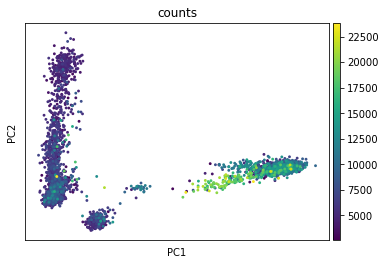

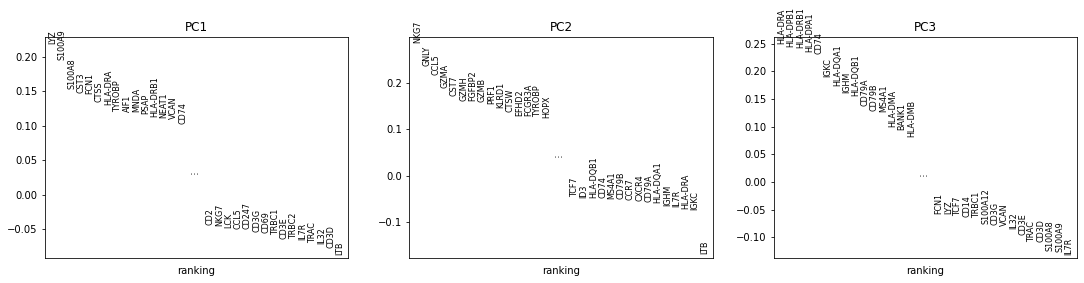

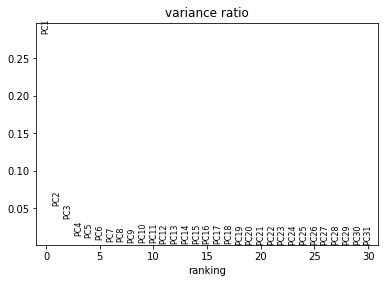

In [27]:
fig = plt.figure()
p10 = sc.pl.pca_overview(adata, color='counts')
plt.show()

別の主成分の組み合わせでプロットする場合は、pca関数を使う。

<Figure size 432x288 with 0 Axes>

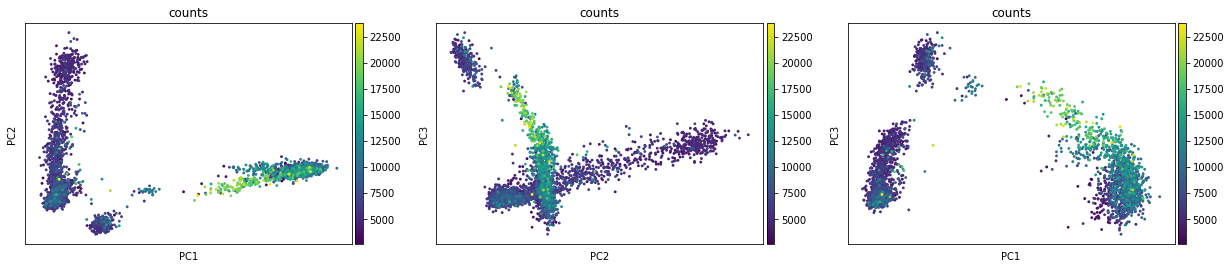

In [28]:
fig = plt.figure()
p10 = sc.pl.pca(adata, color='counts', 
                components=['1,2', '2,3', '1,3'])
plt.show()

# 非線形次元削減

PCA: 0.0014 sec
MDS: 0.92 sec


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


t-SNE: 2.4 sec
UMAP: 7.7 sec


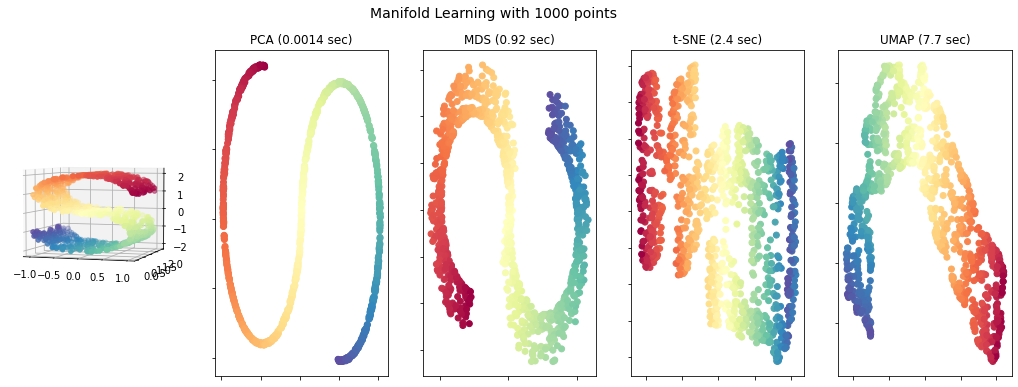

In [29]:
from time import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.decomposition import PCA
import umap

n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
n_components = 2

fig = plt.figure(figsize=(18, 6))
plt.suptitle(f"Manifold Learning with {n_points} points", fontsize=14)
ax = fig.add_subplot(151, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

def plot2d(model, model_name, index):
    t0 = time()
    Y = model.fit_transform(X)
    t1 = time()
    print(f"{model_name}: {t1-t0:.2g} sec")
    ax = fig.add_subplot(1, 5, index)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title(f"{model_name} ({t1-t0:.2g} sec)")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

model = PCA(n_components=2)
plot2d(model, 'PCA', 2)

model = manifold.MDS(n_components=2, max_iter=100, n_init=1)
plot2d(model, 'MDS', 3)

model = manifold.TSNE(n_components=2, 
                      init='pca', perplexity=50, random_state=0)
plot2d(model, 't-SNE', 4)

model = umap.UMAP(n_components=2, 
                  n_neighbors=30, min_dist=0.3, random_state=0)
plot2d(model, 'UMAP', 5)

plt.show()

## t分布型確率的近傍埋め込み（t-SNE）

まず、t-SNE, UMAP共通のステップとして、データから「近傍グラフ」（neighborhood graph）の構築が必要。



In [30]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


データ点間の接続関係（細胞の近傍関係）は、全細胞vs.全細胞のペアの情報を記録する ***obsp*** に格納される。

In [31]:
adata.obsp['connectivities']

<3702x3702 sparse matrix of type '<class 'numpy.float32'>'
	with 80330 stored elements in Compressed Sparse Row format>

t-SNEの実行。

データに適用するさまざまな手法（tool）は、scanpy.tlに揃っている。

In [32]:
sc.tl.tsne(adata) 

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:07)


<Figure size 432x288 with 0 Axes>

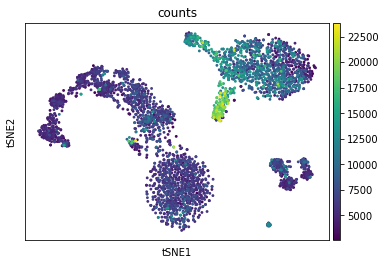

In [33]:
fig = plt.figure()
p10 = sc.pl.tsne(adata, color='counts')
plt.show()

パープレキシティはデフォルトで "30" に設定されている。

パープレキシティを "5" に変更して実行してみる。

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:06)


<Figure size 432x288 with 0 Axes>

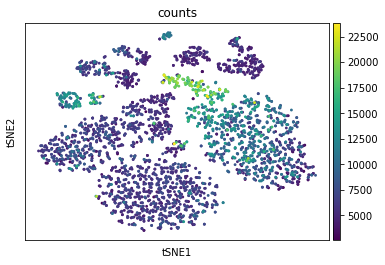

In [34]:
sc.tl.tsne(adata, perplexity=5) 

fig = plt.figure()
p10 = sc.pl.tsne(adata, color='counts')
plt.show()

つぎに、パープレキシティを "500" に設定してみる。

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:27)


<Figure size 432x288 with 0 Axes>

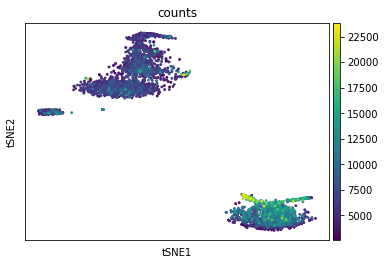

In [35]:
sc.tl.tsne(adata, perplexity=500) 

fig = plt.figure()
p10 = sc.pl.tsne(adata, color='counts')
plt.show()

## UMAP

近傍グラフはすでに計算しているので、scanpy.tlのumap関数を使えばオーケー。

In [36]:
sc.tl.umap(adata) 

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


プロットはt-SNEとほとんど同じ。scanpy.pl以下にumap用の描画関数がある。

<Figure size 432x288 with 0 Axes>

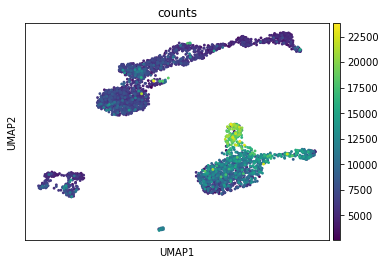

In [37]:
fig = plt.figure()
p10 = sc.pl.umap(adata, color='counts')
plt.show()

ここでもパラメータを色々変えて結果を比較してみよう。

重要なパラメータは2つ: n_neighbors, min_dist

n_neighborsに関しては、scanpy.pp.neighborsで近傍グラフを構築したときにすでに設定している。デフォルトでは n_neighbors=15 となっている。

そこでここでは、min_distによる変化を見てみよう。

デフォルトではmin_dist=0.5なので、0.1と1.0に変化させて計算してみる。

In [38]:
adata_md01 = sc.tl.umap(adata, min_dist=0.1, copy=True)
adata_md10= sc.tl.umap(adata, min_dist=1.0, copy=True)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


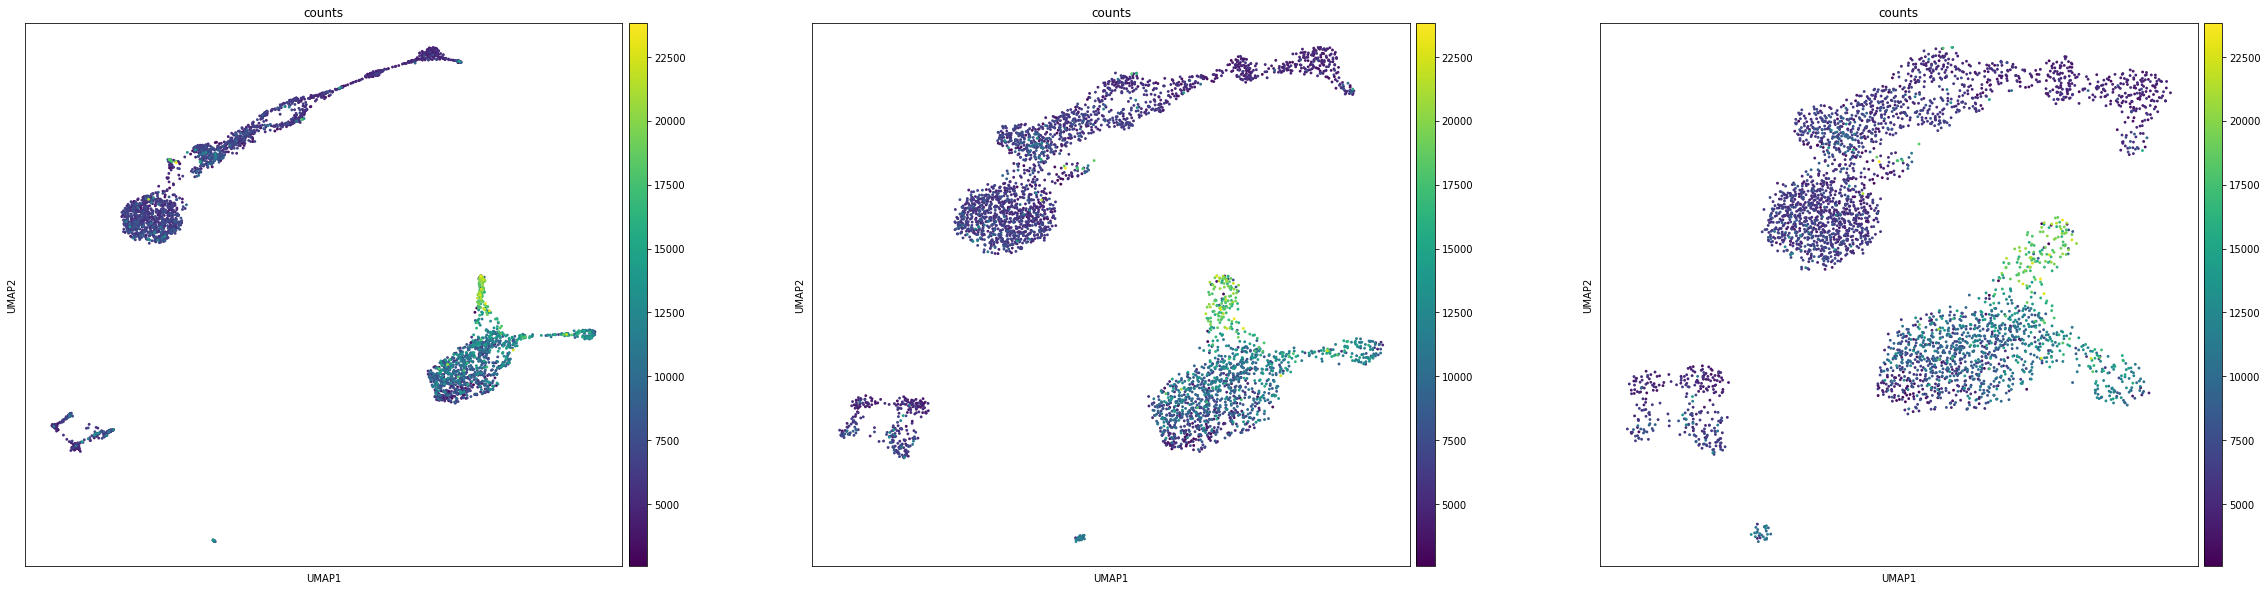

In [39]:
rcParams['figure.figsize']=(40,10)

fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)

p12 = sc.pl.umap(adata_md01, color='counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p12 = sc.pl.umap(adata, color='counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata_md10, color='counts', ax=fig.add_subplot(fig_ind[2]), show=False)

plt.show()

# クラスタリング

Leidenクラスタリングを実行してみる。

モジュラリティの計算に影響を与える "resolution" パラメータが存在する。

いくつかの値で結果を比較してみる。

In [40]:
sc.tl.leiden(adata, resolution=1.5, key_added='leiden_r1.5')
sc.tl.leiden(adata, resolution=1.0, key_added='leiden_r1.0')
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_r0.5')

running Leiden clustering
    finished: found 17 clusters and added
    'leiden_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_r1.0', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)


それぞれのクラスタリング結果は観測値の "obs" に格納された。

In [41]:
adata.obs

,counts,n_genes,percent_mito,n_counts,doublet_score,doublet,leiden_r1.5,leiden_r1.0,leiden_r0.5
AAACCCAAGAGACAAG-1,7359.0,2359,6.332382,7353.0,0.020870,False,0,1,0
AAACCCAAGGCCTAGA-1,3764.0,1255,9.112646,3759.0,0.004889,False,1,0,1
AAACCCAGTCGTGCCA-1,4894.0,1575,13.179403,4887.0,0.019183,False,6,3,2
AAACCCATCGTGCATA-1,6700.0,1905,6.358209,6696.0,0.025000,False,6,3,2
AAACGAAAGACAAGCC-1,3894.0,1587,9.322034,3884.0,0.016357,False,0,1,0
...,...,...,...,...,...,...,...,...,...
TTTGGTTGTACGAGTG-1,5662.0,1450,6.481809,5656.0,0.016357,False,1,0,1
TTTGTTGAGTTAACAG-1,10189.0,3065,8.774168,10178.0,0.010656,False,11,2,0
TTTGTTGCAGCACAAG-1,4740.0,1641,9.852321,4738.0,0.009968,False,5,4,3
TTTGTTGCAGTCTTCC-1,6367.0,1900,8.685410,6350.0,0.005571,False,6,3,2


それぞれによってクラスタリング結果がどのように異なるのかプロットしてみる。

プロットする点の座標じたいはUMAPの結果なので、プロットはUMAP版の関数を使い、色分けだけをクラスタリング結果で指定すればいい。

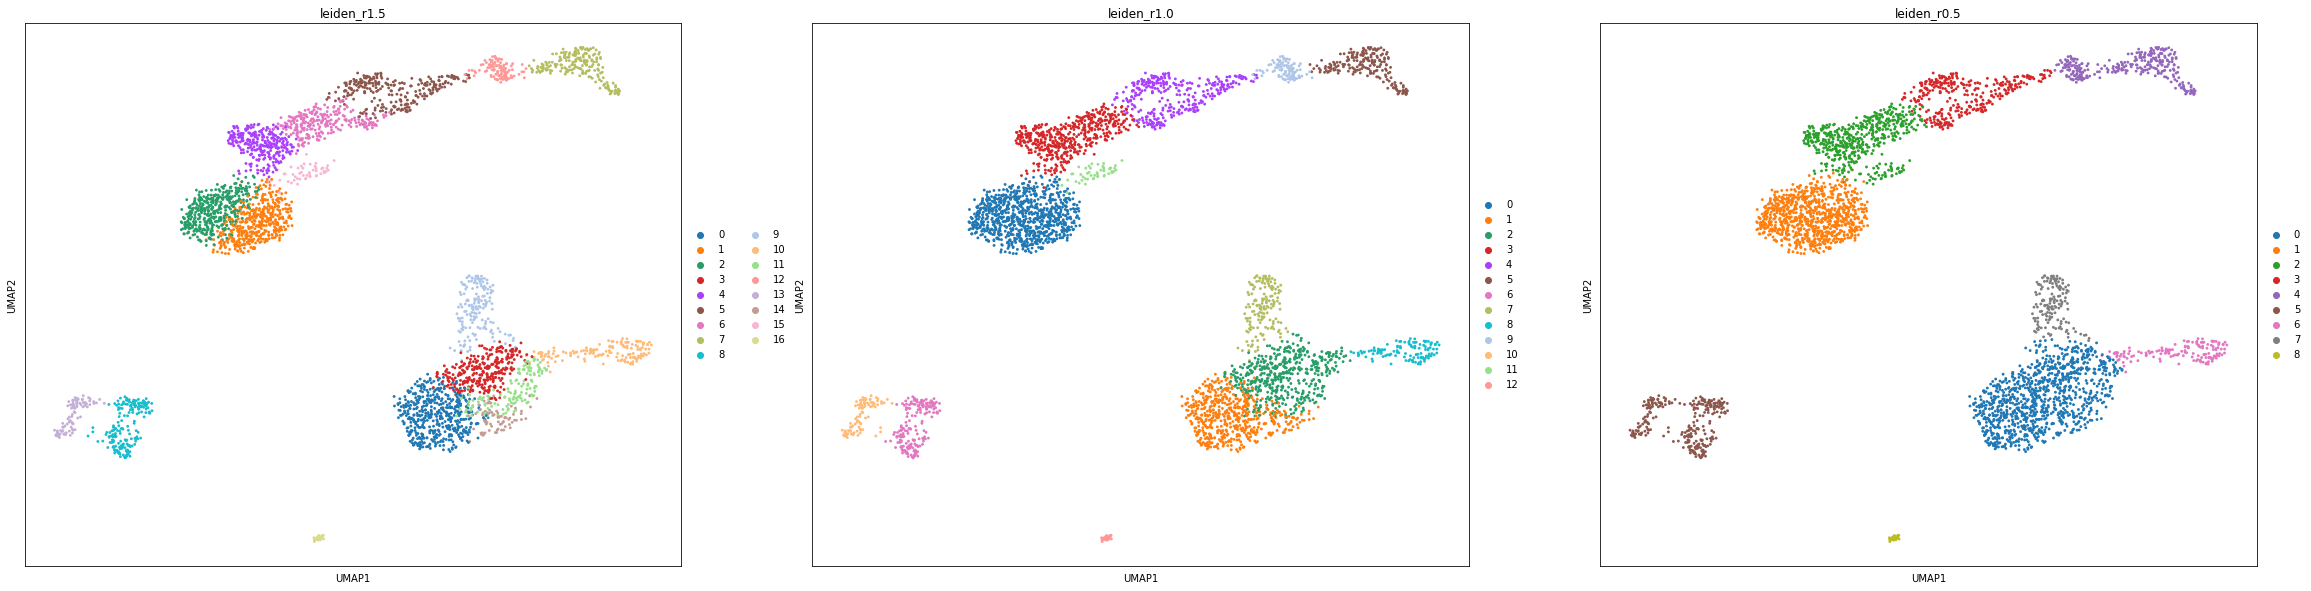

In [42]:
rcParams['figure.figsize']=(40,10)

fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)

p12 = sc.pl.umap(adata, color='leiden_r1.5', ax=fig.add_subplot(fig_ind[0]), show=False)
p12 = sc.pl.umap(adata, color='leiden_r1.0', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata, color='leiden_r0.5', ax=fig.add_subplot(fig_ind[2]), show=False)

plt.show()